In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_text

import xgboost as xgb

In [2]:
URL = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"

In [3]:
df = pd.read_csv(URL)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.shape

(20640, 10)

- Preparing the dataset

In [5]:
df = df[(df["ocean_proximity"] == "<1H OCEAN") | (df["ocean_proximity"] == "INLAND")]
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN


In [6]:
df["ocean_proximity"] = df["ocean_proximity"].str.replace("<", "")

In [7]:
df.shape

(15687, 10)

In [8]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [9]:
df.fillna(0, inplace=True)
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:

df["median_house_value"] = np.log1p(df["median_house_value"])
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = df_train["median_house_value"].values
y_val = df_val["median_house_value"].values
y_test = df_test["median_house_value"].values

In [13]:
del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [14]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
test_dicts = df_test.to_dict(orient='records')

In [15]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
X_test = dv.transform(test_dicts)

**Question 1:**

In [16]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [17]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- ocean_proximity=1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=1H OCEAN >  0.50
|   |--- value: [12.30]



*Answer:* ocean_proximity

**Question 2:**

In [18]:
rf = RandomForestRegressor(
    n_estimators=10,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
y_pred = rf.predict(X_val)
rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
print(rmse)

0.245


*Answer:* 0.245

**Question 3:**

In [20]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(
        n_estimators=n,
        random_state=1,
        n_jobs=-1
        )
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
    scores.append((n, rmse))

In [21]:
scores_columns = ["n_estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=scores_columns)

In [22]:
df_scores

,n_estimators,rmse
0,10,0.245
1,20,0.238
2,30,0.236
3,40,0.235
4,50,0.235
5,60,0.234
6,70,0.234
7,80,0.234
8,90,0.234
9,100,0.234


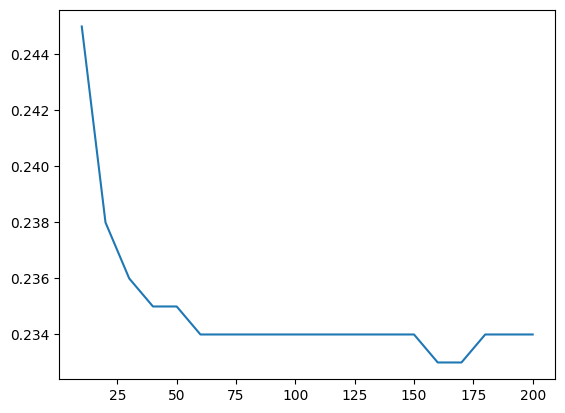

In [23]:
plt.plot(df_scores['n_estimators'], df_scores['rmse'])

*Answer:* 50

**Question 4:**

In [24]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(
            n_estimators=n, 
            max_depth=d,
            random_state=1,
            n_jobs=-1
            )
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_val)
        rmse = round(np.sqrt(mean_squared_error(y_val, y_pred)), 3)
        scores.append((n, d, rmse))

In [25]:
scores_columns = ["n_estimators","max_depth", "rmse"]
df_scores = pd.DataFrame(
    scores,
    columns=scores_columns
    )

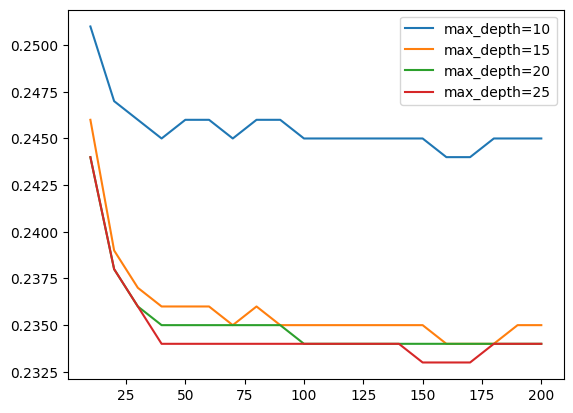

In [26]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'],
             label = f'max_depth={d}')
plt.legend()

*Answer:* 25

**Question 5:**

In [27]:
rf = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [28]:
rf.feature_importances_

array([0.01504314, 0.03006329, 0.10266505, 0.08585341, 0.33548579,
       0.21881985, 0.14745955, 0.02811472, 0.01543366, 0.02106153])

In [29]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by="importance", ascending=False)

,feature,importance
4,median_income,0.335486
5,ocean_proximity=1H OCEAN,0.218820
6,ocean_proximity=INLAND,0.147460
2,latitude,0.102665
3,longitude,0.085853
1,housing_median_age,0.030063
7,population,0.028115
9,total_rooms,0.021062
8,total_bedrooms,0.015434
0,households,0.015043


*Answer:* median_income

**Question 6:**

In [30]:
scores = {}

In [31]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [32]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [33]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=100)

In [34]:
def parse_xgb_output(output):
    results = []
    tree=[]
    rmse_train = []
    rmse_val = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])
        
        results.append((it, train, val))

    columns = ["num_iter", "train_rmse", "val_rmse"]
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [35]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

In [36]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, 
                  verbose_eval = 5,
                  evals = watchlist, 
                  num_boost_round=100)

In [37]:
key = f"eta={xgb_params['eta']}"
scores[key] = parse_xgb_output(output)

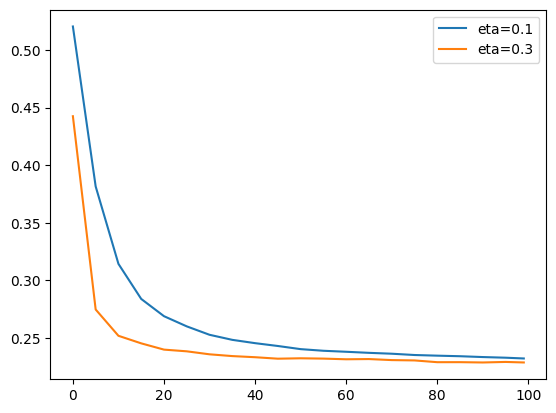

In [38]:
etas = ["eta=0.1", "eta=0.3"]

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score["num_iter"], df_score["val_rmse"], label=eta)
plt.legend()

*Answer:* 0.3